# Train car - v3

```
data ; crop and resize  
network ; xception , decrease batch_size. 

ImageAugment  ; shift add. 
random_eraser ; image part remove

batch 16
earlystop ; val_loss 
first 200 epoch.
train acc;  , val acc;  , lb acc;   
model1 ; 66epoch, 93, 82     
model2; 80epoch,  92, 78      
model3 ; 97epoch.(earlystop), 94, 80  ;  lb 82  

earlystop;f1_score , batch 32  
val_acc is very similar with val_new_score(f1score).
97, 85 ; -> lb 86.8  
96, 84
97, 84
upper3 model ensamble ==> lb 91.582
```

## train ready

In [1]:
import sys
import pandas as pd

# from keras.applications import mobilenetv2
from keras.applications import xception
from keras.preprocessing import image
# import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Using TensorFlow backend.


In [2]:
cache=False
basedir = './'

x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [3]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
imgwidth=224
imgheight=224

In [5]:
# cross validation
cvmode=1
datacnt = x_trainall.shape[0]
if cvmode==1:
    modelpath='car-v3-1.h5'
    # 7000, 2990
    print('cvmode=1')
    x_train = x_trainall[:7000]
    y_train = y_trainall[:7000]
    x_val = x_trainall[7000:]
    y_val = y_trainall[7000:]
elif cvmode==2:
    modelpath='car-v3-2.h5'
    print('cvmode=2')
    x_train = x_trainall[datacnt-7000:]
    y_train = y_trainall[datacnt-7000:]
    x_val = x_trainall[:datacnt-7000]
    y_val = y_trainall[:datacnt-7000]
elif cvmode==3:
    modelpath='car-v3-3.h5'
    print('cvmode=3')
    x_train = x_trainall[1000:8000]
    y_train = y_trainall[1000:8000]
    x_val = np.append( x_trainall[:1000], x_trainall[8000:] , axis=0 )
    y_val = np.append( y_trainall[:1000], y_trainall[8000:] )
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

cvmode=1
(7000, 224, 224, 3) (7000,) (2990, 224, 224, 3) (2990,)
0 195


In [6]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [7]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [8]:
# Image Augumentation
batch_size=32  # 32, 64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, 
                              width_shift_range=0.1, height_shift_range=0.1,
                              fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=1),)
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=False)

In [14]:
# metric f1 micro score
# def new_score(y_true, y_pred):
#    return f1_score(y_true, y_pred, average='micro')

In [6]:
def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
### checkpoint save weights in progress...
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
checkpoint_path='ckpt/check_{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, period=10)


es_callback = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001 )
# es_callback = EarlyStopping(monitor='val_new_score', patience=20, min_delta=0.001 )


# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [20]:
force = False

if os.path.exists(modelpath) and force==False :
    cache=True
    print('cache model use... continuous!')
else:
    cache=False
    print('no cache model. create new model!')

cache model use... continuous!


In [21]:
# cache=True
# model
if cache==True:
    print('load model...', modelpath)
    model = load_model(modelpath, custom_objects={'new_score': new_score})
else:
    inputs = Input(shape=(224,224,3))
#     net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet', pooling='max')
    net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)

    model = Model(inputs=inputs, outputs=net2)
    print('new model...')

model.summary()

load model... car-v3-1.h5
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________

In [13]:
##### model freeze. after acc 90.
if True:
    print('freezing...')
    for layer in model.layers[:-4]:
        layer.trainable=False
#     for layer in model.layers:
#         print(layer, layer.trainable)
#     model.summary()

freezing...


In [14]:
if False:
    print('load weights...')
    model.load_weights('ckpt/check_0180.ckpt')

In [12]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', new_score])

NameError: name 'model' is not defined

In [16]:
# epochs = 100
hist = model.fit_generator( train_generator, initial_epoch=0, epochs = 500, validation_data=val_generator, 
                           callbacks=[tensorboard, cp_callback, es_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Epoch 1/500
219/218 [==============================] - 51s 235ms/step - loss: 0.1332 - acc: 0.9616 - new_score: 0.9646 - val_loss: 0.9125 - val_acc: 0.8247 - val_new_score: 0.8336
Epoch 2/500
219/218 [==============================] - 48s 221ms/step - loss: 0.1037 - acc: 0.9682 - new_score: 0.9700 - val_loss: 0.9261 - val_acc: 0.8237 - val_new_score: 0.8291
Epoch 3/500
219/218 [==============================] - 49s 222ms/step - loss: 0.1123 - acc: 0.9639 - new_score: 0.9662 - val_loss: 0.8953 - val_acc: 0.8301 - val_new_score: 0.8362
Epoch 4/500
219/218 [==============================] - 48s 221ms/step - loss: 0.1128 - acc: 0.9678 - new_score: 0.9698 - val_loss: 0.9121 - val_acc: 0.8301 - val_new_score: 0.8374
Epoch 5/500
219/218 [==============================] - 49s 222ms/step - loss: 0.0993 - acc: 0.9687 - new_score: 0.9711 - val_loss: 0.8778 - val_acc: 0.8344 - val_new_score: 0.8417
Epoch 6/500
219/218 [==============================] - 49s 222ms/step - loss: 0.0927 - acc: 0.9703 -

In [22]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
# or 
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

[0.7024641443654446, 0.8595317724955122, 0.8654237855636954]


In [18]:
model.save(modelpath)

### Submission

In [8]:
# test data load for submission
x_test = np.load('x_test.npy')
x_test = x_test/255.

In [9]:
# one model submission 
predictions = model.predict( x_test )
pdi = np.argmax(predictions, axis=1)
print(pdi, np.min(pdi), np.max(pdi))

NameError: name 'model' is not defined

In [12]:
# ensamble. submission.
if True:
    mp='car-v3-1.h5'
    mo = load_model(mp, custom_objects={'new_score': new_score})
    prediction1 = mo.predict( x_test )
    print('model1:', prediction1)

    mp='car-v3-2.h5'
    mo = load_model(mp, custom_objects={'new_score': new_score})
    prediction2 = mo.predict( x_test )
    print('model2:', prediction2)

    mp='car-v3-3.h5'
    mo = load_model(mp, custom_objects={'new_score': new_score})
    prediction3 = mo.predict( x_test )
    print('model3:', prediction3)

    predictions = prediction1+prediction2 +prediction3
    pdi = np.argmax(predictions, axis=1)
    print('final:', pdi, np.min(pdi), np.max(pdi))

model1: [[2.1139986e-10 0.0000000e+00 0.0000000e+00 ... 1.3935689e-24
  0.0000000e+00 3.1142922e-25]
 [5.9939582e-20 3.3770335e-22 2.7061123e-21 ... 1.3483209e-24
  6.4459053e-27 3.9242761e-15]
 [1.9131687e-38 6.8291620e-32 4.8545446e-34 ... 3.2070107e-31
  3.5598486e-29 4.9077968e-12]
 ...
 [0.0000000e+00 6.6666467e-10 1.6614234e-17 ... 1.1257692e-29
  4.4455258e-15 1.1175102e-31]
 [0.0000000e+00 9.2554843e-18 8.8536403e-25 ... 0.0000000e+00
  2.6528404e-09 9.9512054e-29]
 [0.0000000e+00 7.1520600e-19 3.6818087e-24 ... 9.5909099e-26
  5.0773225e-10 5.1806897e-23]]
model2: [[2.6473029e-12 0.0000000e+00 0.0000000e+00 ... 6.4394892e-13
  1.7701384e-21 1.3347427e-23]
 [3.6590993e-25 1.7573225e-26 6.3840812e-26 ... 1.2016798e-21
  1.2355894e-22 1.7850580e-18]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.8642184e-36
  1.4602214e-33 1.4149637e-21]
 ...
 [3.3804638e-38 5.0844131e-27 1.1299450e-30 ... 4.1951894e-26
  3.8629030e-26 0.0000000e+00]
 [5.4532880e-31 1.2937646e-14 1.7056856e-18

In [13]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


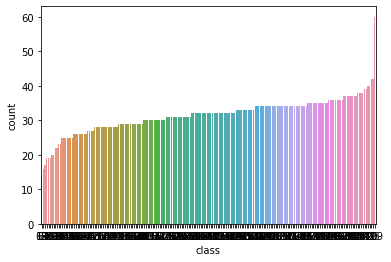

In [14]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)